## imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# for neural network
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from copy import deepcopy

# for splitting data and evaluating results
from sklearn.model_selection import train_test_split

# to track progress
from tqdm.notebook import tqdm

In [ ]:
np.random.seed(0)
torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## get data

In [ ]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.MNIST(
    root="./data", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="./data", train=False, transform=transform, download=True
)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
train_inputs, train_labels = zip(*train_dataset)
test_inputs, test_labels = zip(*test_dataset)

def toNumpy(x):
  return np.array([i.numpy().squeeze() for i in x])

train_inputs, train_labels = toNumpy(train_inputs), np.array(train_labels)
test_inputs, test_labels = toNumpy(test_inputs), np.array(test_labels)

# split train into train and validation
train_inputs, val_inputs, train_labels, val_labels = train_test_split(train_inputs, train_labels, test_size=0.25, random_state=0)

print("shapes")
print("train_inputs",train_inputs.shape)
print("train_labels",train_labels.shape)
print()
print("test_inputs",test_inputs.shape)
print("test_labels",test_labels.shape)
print()
print("val_inputs",val_inputs.shape)
print("val_labels",val_labels.shape)

shapes
train_inputs (45000, 28, 28)
train_labels (45000,)

test_inputs (10000, 28, 28)
test_labels (10000,)

val_inputs (15000, 28, 28)
val_labels (15000,)


## visualize

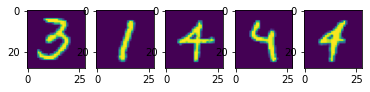

In [ ]:
fig, axs = plt.subplots(1,5)
for i in range(5):
  axs[i].imshow(train_inputs[i])

## create dataset and dataloader

In [ ]:
# custom dataset class
class mydataset(Dataset):
  def __init__(self, inputs, outputs, transform):
    self.inputs = inputs
    self.outputs = outputs
    self.transform = transform

  def __len__(self):
    return len(self.inputs)

  def __getitem__(self, index):
    input = self.transform(self.inputs[index])
    output = self.transform(self.outputs[index])
    return input,output
    
transform = torchvision.transforms.ToTensor()
train_dataset = mydataset(train_inputs, train_inputs, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)

val_dataset = mydataset(val_inputs, val_inputs, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=1000, shuffle=False)

test_dataset = mydataset(test_inputs, test_inputs, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

dataloaders = {"train":train_loader, "val":val_loader}

## define autoencoder

In [ ]:
def train_model(model,criterion,optimizer,dataloaders,epochs,check_every=None,earlyStopping=False):

  print("training model")
  optimizer.zero_grad()

  if not check_every:
      check_every = int(epochs / 10) if epochs > 10 else 1

  phases = dataloaders.keys()
  valExists = True if "val" in phases else False
  avg_loss = {phase:0 for phase in phases}
  avg_losses = {phase:[] for phase in phases}

  for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times

    batchLoss = {phase:[] for phase in phases}

     # Each epoch has a training and validation phase
    for phase in phases:
      if phase == "train":  model.train()  # Set model to training mode
      else: model.eval()   # Set model to evaluate mode
        
      for i, (inputBatch,outTrueBatch) in enumerate(tqdm(dataloaders[phase], leave=False)):

          inputBatch = inputBatch.to(device).float()
          outTrueBatch = outTrueBatch.to(device).float()

          # forward
          with torch.set_grad_enabled(not phase=="val"):
            outPredBatch = model(inputBatch)
          loss = criterion(outTrueBatch, outPredBatch)
          batchLoss[phase].append(loss.item())

          # backward + optimize only if in training phase
          if phase == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()


    for phase in phases : avg_loss[phase] = np.mean(batchLoss[phase])
        
    phase = "val" if valExists else "train"
    if epoch > 0:
      if avg_loss[phase] < min(avg_losses[phase]):
        best_params = deepcopy(model.state_dict())
        best_epoch, best_loss = epoch, avg_loss[phase]
    else:
      best_params = deepcopy(model.state_dict())
      best_epoch, best_loss = epoch, avg_loss[phase]
      movAvg_old = avg_loss[phase]

    for phase in phases : avg_losses[phase].append(avg_loss[phase])  

    # print statistics
    if epoch % check_every == check_every - 1:
      print("epoch: %d" % (epoch + 1), end="  | ")
      for phase in phases:
        print("%s loss: %.3f" % (phase, avg_loss[phase]), end=", ")
      print(" | ", end='')
      for phase in phases:        
        print("avg %s loss: %.3f" % (phase, np.mean(avg_losses[phase][epoch+1-check_every:epoch+1])), end=", ")
      if valExists:
        movAvg_new = np.mean(avg_losses["val"][epoch+1-check_every:epoch+1])

      if (valExists) and earlyStopping:
        if movAvg_old < movAvg_new:   break
        else:   movAvg_old = movAvg_new



  last_params = deepcopy(model.state_dict())
  print('Finished Training')
  for phase in phases:  plt.plot(avg_losses[phase], label=phase+" loss")
  #plt.plot([best_loss]*epoch, linestyle='dashed')
  plt.plot(best_epoch, best_loss, 'o')
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.legend()
  plt.show()

  return best_params, last_params

In [ ]:
class AutoEncoder(nn.Module):
  def __init__(self):
    super(AutoEncoder, self).__init__()

    self.encoder = nn.Sequential(
      nn.Linear(28 * 28, 64),
      nn.ReLU(inplace=True),
      nn.Linear(64, 32),
      nn.ReLU(inplace=True),
      nn.Linear(32, 25))
    
    self.decoder = nn.Sequential(
      nn.Linear(25, 32),
      nn.ReLU(inplace=True), 
      nn.Linear(32, 64),
      nn.ReLU(inplace=True), 
      nn.Linear(64, 28 * 28))

  def forward(self, x):
    size = x.size()
    x = x.view(-1, np.prod(size[1:]))
    x = self.encoder(x)
    x = self.decoder(x)
    x = x.view(size)
    return x

In [ ]:
class ConvAutoEncoder(nn.Module):
  def __init__(self):
    super(ConvAutoEncoder, self).__init__()
    self.encoder = nn.Sequential(
      nn.Conv2d(1, 4, 3, stride=2),
      nn.ReLU(True),
      nn.Conv2d(4, 8, 3, stride=2),
      nn.ReLU(True),
      nn.Conv2d(8, 16, 3, stride=1),
      nn.ReLU(True),
      nn.Conv2d(16, 64, 3, stride=1)
    )
    self.decoder = nn.Sequential(
      nn.ConvTranspose2d(64, 16, 3, stride=1),
      nn.ReLU(True),  
      nn.ConvTranspose2d(16, 8, 3, stride=1),
      nn.ReLU(True),
      nn.ConvTranspose2d(8, 4, 3, stride=2),
      nn.ReLU(True),
      nn.ConvTranspose2d(4, 1, 4, stride=2)
    )

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

In [ ]:
model = AutoEncoder().to(device)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

#Define a Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

107049


training model


epoch: 3  | train loss: 0.126, val loss: 0.122,  | avg train loss: 0.154, avg val loss: 0.131, 

epoch: 6  | train loss: 0.108, val loss: 0.107,  | avg train loss: 0.113, avg val loss: 0.111, 

epoch: 9  | train loss: 0.100, val loss: 0.100,  | avg train loss: 0.102, avg val loss: 0.101, 

epoch: 12  | train loss: 0.095, val loss: 0.095,  | avg train loss: 0.097, avg val loss: 0.096, 

epoch: 15  | train loss: 0.092, val loss: 0.093,  | avg train loss: 0.093, avg val loss: 0.094, 

epoch: 18  | train loss: 0.091, val loss: 0.091,  | avg train loss: 0.091, avg val loss: 0.091, 

epoch: 21  | train loss: 0.090, val loss: 0.090,  | avg train loss: 0.090, avg val loss: 0.090, 

epoch: 24  | train loss: 0.089, val loss: 0.089,  | avg train loss: 0.089, avg val loss: 0.089, 

epoch: 27  | train loss: 0.088, val loss: 0.088,  | avg train loss: 0.088, avg val loss: 0.089, 

epoch: 30  | train loss: 0.087, val loss: 0.088,  | avg train loss: 0.088, avg val loss: 0.088, 
Finished Training


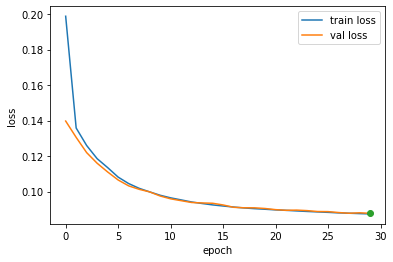

In [ ]:
best_params, last_params = train_model(model, criterion, optimizer, dataloaders, epochs=30)

In [ ]:
model.load_state_dict(best_params)

<All keys matched successfully>

## evaluate

In [ ]:
def evaluate(model,inputs,transform,n_samples=5):
  model.eval()
  
  fig, axs = plt.subplots(2,n_samples)
  for i,input in enumerate(inputs[:n_samples]):
    axs[0][i].imshow(input)
    input = transform(input).unsqueeze(0).to(device).float()
    with torch.no_grad():
      output = model(input)
    output = output.view(input.shape[1:]).squeeze().cpu()
    axs[1][i].imshow(output)
  plt.show()

train sample visualized


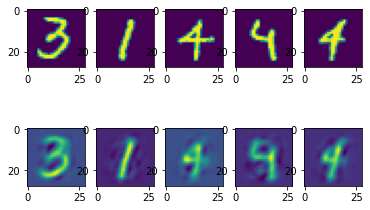

test sample visualized


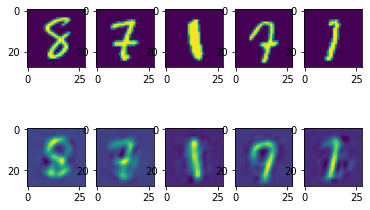

In [ ]:
print("train sample visualized")
evaluate(model,train_inputs,transform)
print("test sample visualized")
randTestSamples = test_inputs[np.random.choice(test_inputs.shape[0],5,replace=False)]
evaluate(model,randTestSamples,transform)